In [2]:
from obspy.core import Stream, read
import numpy as np
from pytensor.compile.ops import as_op
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import pandas as pd
import os 
import os.path
import pymc as pm
import arviz as az

In [9]:
#get the data
#pwaves = genfromtxt('/Users/sydneydybing/Downloads/DT2019_Cascadia_Amplitudes.txt')
# What exactly are the colunns here? Amplitude of waves at a specific time?
# My equivalent = peak strain at a specific time

#build the target function, misfit to this is what is being minimized
@as_op(itypes=[pt.dvector,pt.dscalar,pt.dscalar,pt.dscalar,pt.dscalar,pt.dscalar], otypes=[pt.dvector])
def two_straight_lines(x,m1,m2,xinter,x0,y0):
    '''
    input x coordiantes are in x
    slopes are m1 and m2
    intercept of left hand line is b1 
    intersection of two lines is at xinter
    
    Note that y intercept of second straight line is dependent on b1 and xinter
      and defined entirely by them (so that the lines touch).
    '''
    
    # Output vector
    y_out = np.ones(len(x))
    
    # Before building the first straight line, calculate the intercept
    b1 = y0 - m1*x0
    
    # Build first straight line segment
    y_out = m1*x + b1
    
    # Find points that are after the intersection and make the second segment
    i = np.where(x>xinter)[0]
    
    # Define second y intercept
    b2 = m1*xinter + b1 - m2*xinter
    
    # Make second straight line
    y_out[i] = m2*x[i] + b2

    return y_out

# Build the target function, misfit to this is what is being minimized
def non_pytensor_two_straight_lines(x,m1,m2,xinter,x0,y0):
    '''
    input x coordiantes are in x
    slopes are m1 and m2
    intercept of left hand line is b1 
    intersection of two lines is at xinter
    
    Note that y intercept of second straight line is dependent on b1 and xinter
      and defined entirely by them (so that the lines touch).
    '''
    
    #output vector
    yout = np.ones(len(x))
    
    #before building the first straight line, calculate the intercept
    b1 = y0 - m1*x0
    
    #build first straight line segment
    yout = m1*x + b1
    
    #find points that are after the intersection and make the second segment
    i = np.where(x>xinter)[0]
    
    #define second y intercept
    b2 = m1*xinter + b1 - m2*xinter
    
    #make second straight line
    yout[i] = m2*x[i] + b2

    return yout

In [155]:
##### Barbour Data Info #####

# quake_folders = np.genfromtxt('/Users/sydneydybing/StrainProject/quake_folders.txt', dtype=str)
# stas = np.genfromtxt('/Users/sydneydybing/StrainProject/stations.txt', dtype=str)

# stas = ['B081', 'B082', 'B084', 'B086', 'B087', 'B088', 'B093']
# test_stas = ['B081', 'B082', 'B084']

path_to_files = '/Users/sydneydybing/StrainProject/2024/'

earthquakes = pd.read_csv(path_to_files + 'M6_catalog_2004-2024.csv', dtype = str)

In [162]:
earthquakes

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
21,2014-03-10T05:18:13.430Z,40.8286667,-125.1338333,16.441,6.8,mw,112,229,0.6568,0.15,...,2022-09-24T19:42:07.982Z,"77 km WNW of Indianola, California",earthquake,0.64,1.88,NaN,5,reviewed,nc,nc


In [157]:
weird_events_only = False
if weird_events_only:
    earthquakes = earthquakes.iloc[[4,15]]

small_test = False
if small_test:
    earthquakes = earthquakes.iloc[[11,12,13,14,15,16]]
    
one_at_a_time = True
if one_at_a_time:
#     earthquakes = earthquakes[:1]
    earthquakes = earthquakes.iloc[[21]]

origin_times = earthquakes.time.values
mags = earthquakes.mag.values

bsm_mda = pd.read_csv(path_to_files + 'bsm_metadata.csv')
NA_only = bsm_mda.loc[bsm_mda['LONG'] < -110]
stas = NA_only['BNUM'].values

eqs_test = earthquakes[4:5]
ots_test = origin_times[4:5]
mags_test = mags[4:5]
rows_for_extra_times = [8,9,14,16]

dist_array = np.load(path_to_files + 'NA_evt-sta_dist_array_less500km_withdata_withrmssnrs.npy')

# Array order:

# 0. Earthquake identifier
# 1. Earthquake origin time
# 2. Earthquake latitude
# 3. Earthquake longitude
# 4. Earthquake magnitude
# 5. Station name
# 6. Station latitude
# 7. Station longitude
# 8. Hypocentral distance (km)
# 9. RMS strain SNR

2014-03-10T05:18:13.430Z


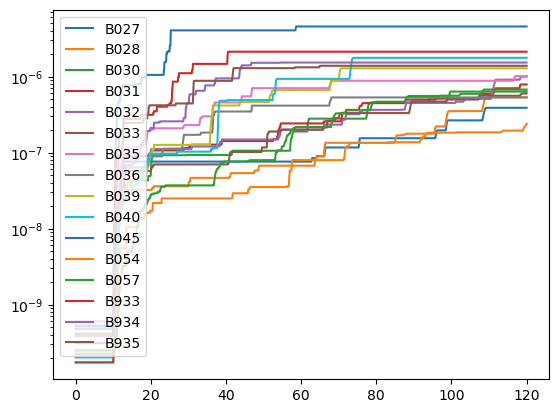

In [158]:
# stas = ['B072', 'B079', 'B082', 'B087', 'B916', 'B917', 'B918', 'B921']

for idx in range(len(earthquakes)):
    
#     print(idx)
        
    ot = origin_times[idx]
    print(ot)
    
    if idx in rows_for_extra_times:
        cut_ot = ot[:13]
    else:
        cut_ot = ot[:10]
    
    eq_id = str(cut_ot) + '_M' + str(mags[idx])
    # print(eq_id)
        
    # Find rows that match this event in the array with the hypocentral distances
    
    i = np.where(dist_array[:,0] == eq_id)[0]
    # print(dist_array[i])
    
    for sta in stas:
        
        # print(sta)
        
        try:
            
            # Find row that matches this station within the rows of the right event
            j = np.where(dist_array[i,5] == sta)[0]
            hypdist = float(dist_array[i][j][0][8])
            int_hypdist = int(hypdist)
            snr = int(float(dist_array[i][j][0][9]))

            # Read in data - peak strain data only has the ones with SNR > 2
            pst = read(path_to_files + 'strain_data/peak_post_p/' + str(eq_id) + '/' + str(sta) + '.mseed')
            plt.plot(pst[0].times(), pst[0].data, label = sta)
            plt.semilogy()
            plt.legend()
                
        except:
            continue # skips to next station
    
    plt.show()

2014-03-10_M6.8
B001
B003
B004
B005
B006
B007
B009
B010
B011
B012
B013
B014
B017
B018
B019
B020
B022
B023
B024
B026
B027


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 2 chains for 1_000 tune and 6_000 draw iterations (2_000 + 12_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


m1 mean: 0.72
m2 mean: 0.0
xinter Mean: 13.08
Smallest distance index:
62


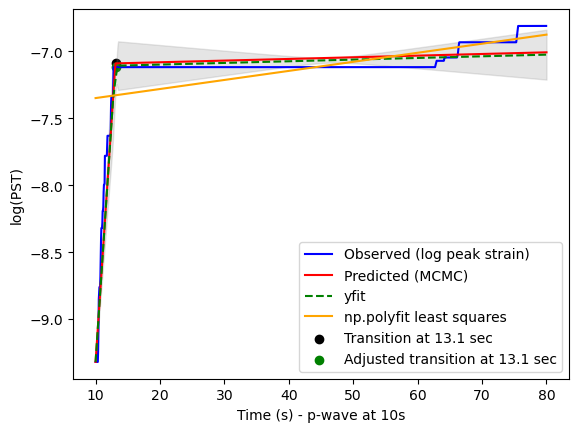

B027 done
B028


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 2 chains for 1_000 tune and 6_000 draw iterations (2_000 + 12_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


m1 mean: 0.61
m2 mean: 0.01
xinter Mean: 13.32
Smallest distance index:
68


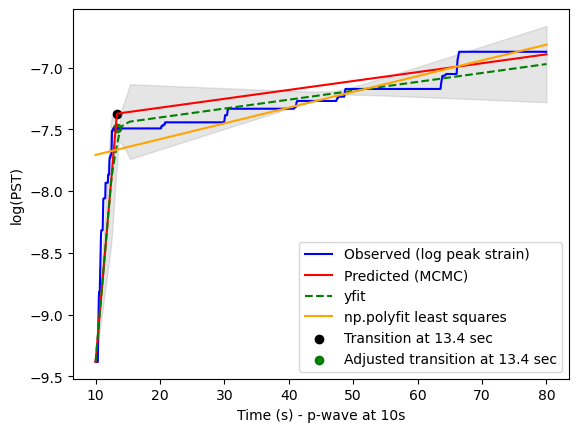

B028 done
B030


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 2 chains for 1_000 tune and 6_000 draw iterations (2_000 + 12_000 draws total) took 22 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


m1 mean: 0.71
m2 mean: 0.01
xinter Mean: 13.27
Smallest distance index:
66


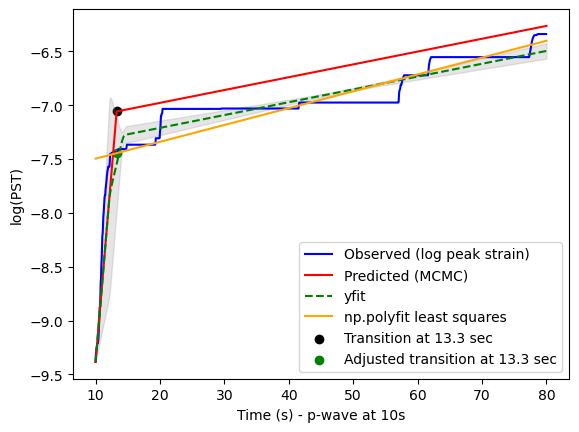

B030 done
B031


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 2 chains for 1_000 tune and 6_000 draw iterations (2_000 + 12_000 draws total) took 19 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


m1 mean: 0.84
m2 mean: 0.01
xinter Mean: 13.18
Smallest distance index:
64


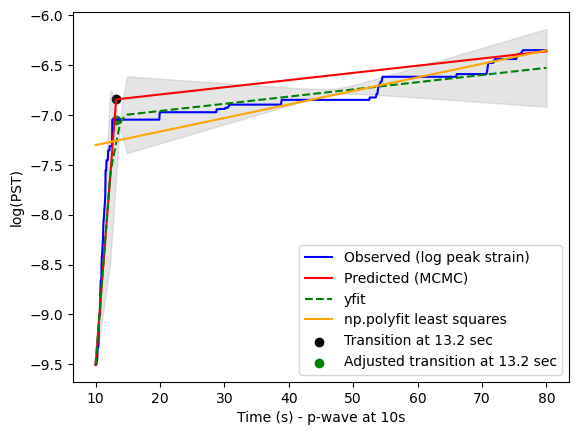

B031 done
B032


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 2 chains for 1_000 tune and 6_000 draw iterations (2_000 + 12_000 draws total) took 19 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


m1 mean: 0.86
m2 mean: 0.01
xinter Mean: 12.71
Smallest distance index:
57


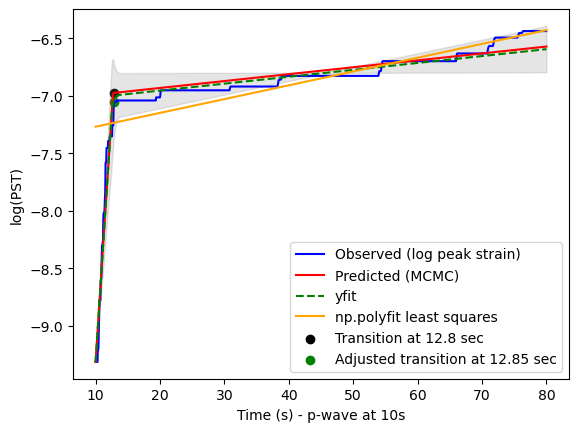

B032 done
B033


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 2 chains for 1_000 tune and 6_000 draw iterations (2_000 + 12_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


m1 mean: 0.86
m2 mean: 0.01
xinter Mean: 12.81
Smallest distance index:
60


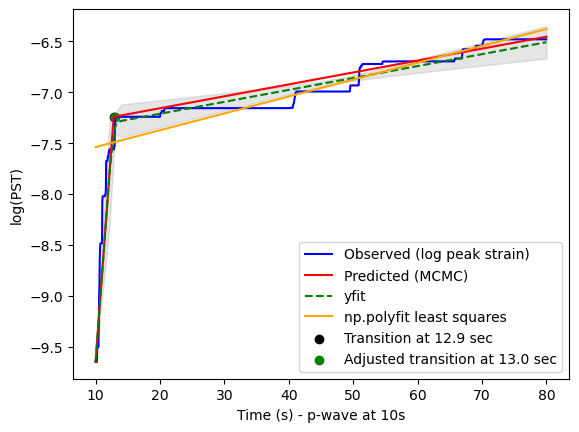

B033 done
B035


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 2 chains for 1_000 tune and 6_000 draw iterations (2_000 + 12_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


m1 mean: 0.92
m2 mean: 0.01
xinter Mean: 12.76
Smallest distance index:
57


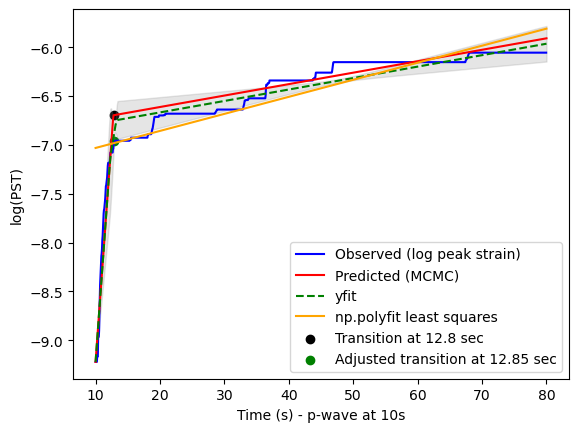

B035 done
B036


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 2 chains for 1_000 tune and 6_000 draw iterations (2_000 + 12_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


m1 mean: 0.94
m2 mean: 0.01
xinter Mean: 12.84
Smallest distance index:
58


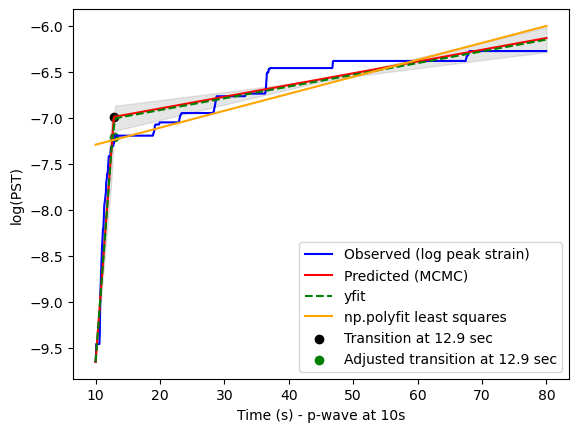

B036 done
B039


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 2 chains for 1_000 tune and 6_000 draw iterations (2_000 + 12_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


m1 mean: 0.92
m2 mean: 0.02
xinter Mean: 12.75
Smallest distance index:
56


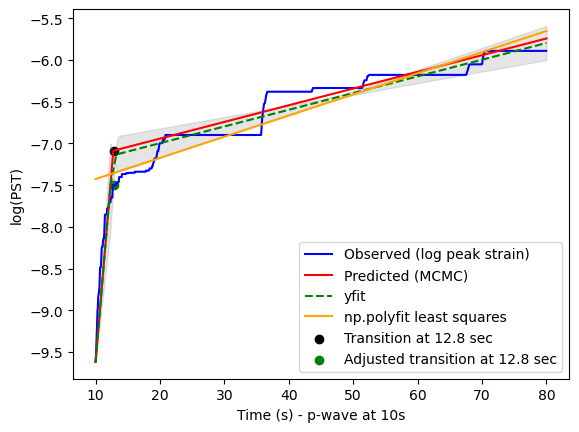

B039 done
B040


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 2 chains for 1_000 tune and 6_000 draw iterations (2_000 + 12_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


m1 mean: 0.67
m2 mean: 0.02
xinter Mean: 14.13
Smallest distance index:
84


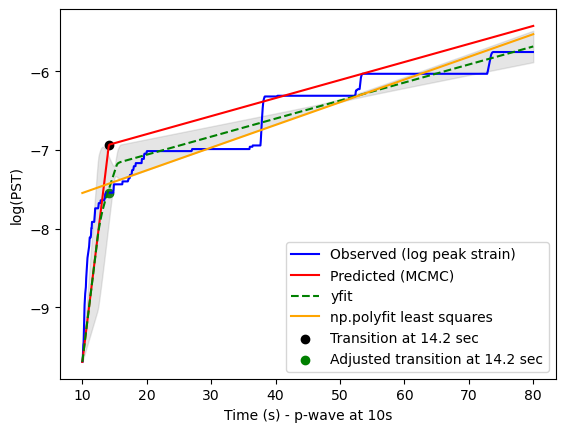

B040 done
B045


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 2 chains for 1_000 tune and 6_000 draw iterations (2_000 + 12_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


m1 mean: 1.19
m2 mean: 0.01
xinter Mean: 13.29
Smallest distance index:
66


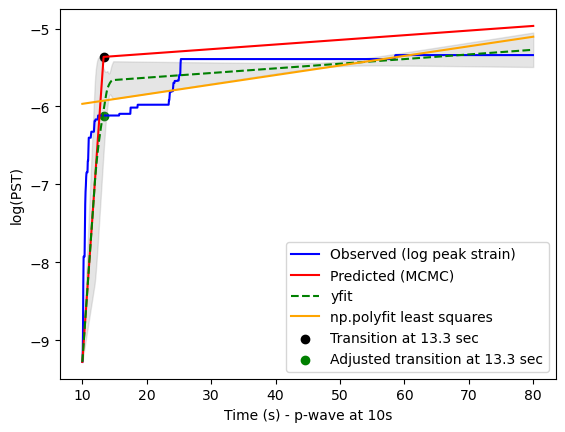

B045 done
B054


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 2 chains for 1_000 tune and 6_000 draw iterations (2_000 + 12_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


m1 mean: 1.0
m2 mean: 0.01
xinter Mean: 12.07
Smallest distance index:
42


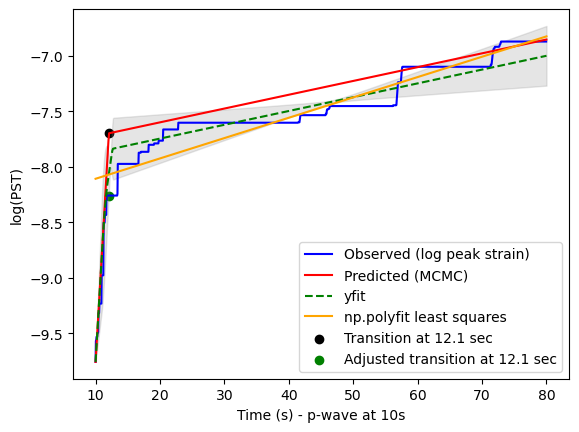

B054 done
B057


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 2 chains for 1_000 tune and 6_000 draw iterations (2_000 + 12_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


m1 mean: 0.31
m2 mean: 0.02
xinter Mean: 16.43
Smallest distance index:
134


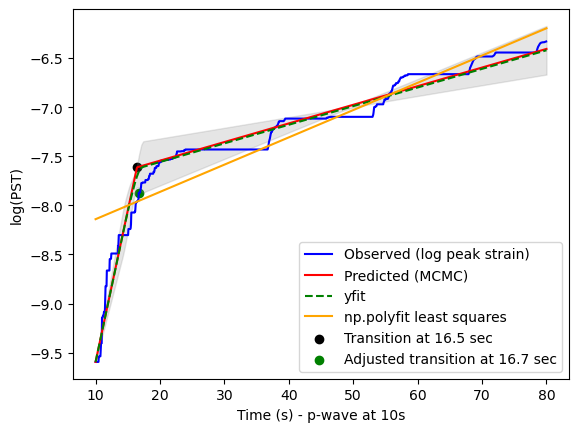

B057 done
B058
B065
B066
B067
B072
B073
B075
B076
B078
B079
B081
B082
B084
B086
B087
B088
B089
B093
B201
B202
B203
B204
B205
B206
B207
B208
B900
B901
B916
B917
B918
B921
B926
B927
B928
B933


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 2 chains for 1_000 tune and 6_000 draw iterations (2_000 + 12_000 draws total) took 19 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


m1 mean: 0.95
m2 mean: 0.01
xinter Mean: 14.29
Smallest distance index:
86


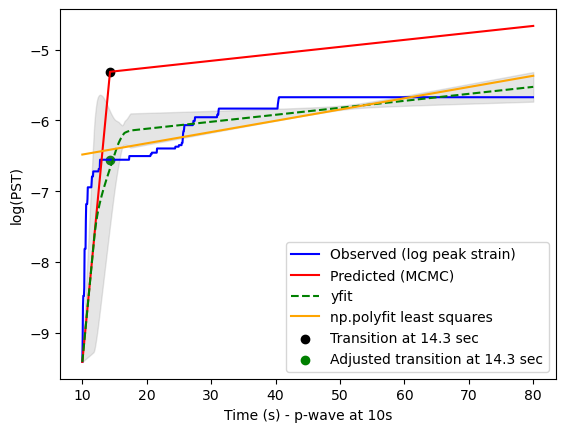

B933 done
B934


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 2 chains for 1_000 tune and 6_000 draw iterations (2_000 + 12_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


m1 mean: 0.78
m2 mean: 0.01
xinter Mean: 13.83
Smallest distance index:
78


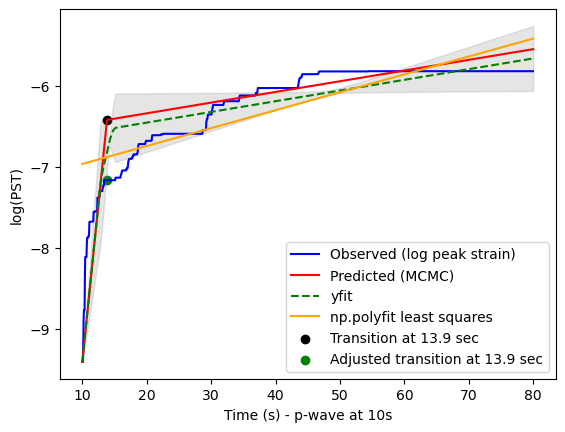

B934 done
B935


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 2 chains for 1_000 tune and 6_000 draw iterations (2_000 + 12_000 draws total) took 21 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


m1 mean: 1.09
m2 mean: 0.01
xinter Mean: 13.2
Smallest distance index:
64


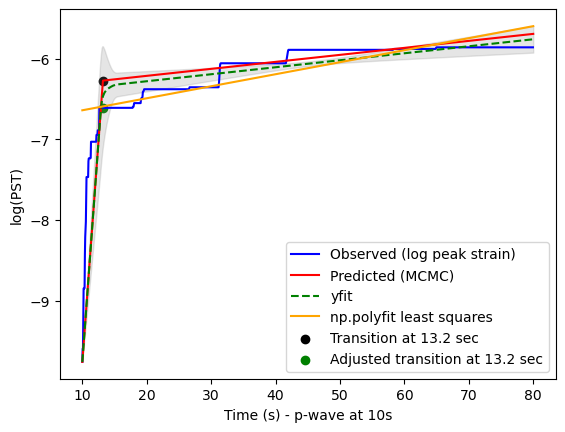

B935 done
B941
B943
B944
B946
B950


In [159]:
# stas = ['B027', 'B028']

events_list = []
mags_list = []
stas_list = []
hypdist_list = []
trans_time_list = []

for idx in range(len(earthquakes)):
        
    ot = origin_times[idx]
    
    if idx in rows_for_extra_times:
        cut_ot = ot[:13]
    else:
        cut_ot = ot[:10]
    
    eq_id = str(cut_ot) + '_M' + str(mags[idx])
    print(eq_id)
    
    # Find rows that match this event in the array with the hypocentral distances
    
    u = np.where(dist_array[:,0] == eq_id)[0]
    # print(dist_array[u])
    
    for sta in stas:
        
        print(sta)
        
        try:
            # Find row that matches this station within the rows of the right event
            j = np.where(dist_array[u,5] == str(sta))[0]
            hypdist = float(dist_array[u][j][0][8])
            int_hypdist = int(hypdist)
            snr = int(float(dist_array[u][j][0][9]))

            # Read in data - peak strain data only has the ones with SNR > 2
            pst = read(path_to_files + 'strain_data/peak_post_p/' + str(eq_id) + '/' + str(sta) + '.mseed')
            # pst.plot()
            # plt.plot(pst[0].times(), pst[0].data)
            # plt.semilogy()

        except:
            continue # skips to next station
            
        times = pst[0].times()
        data = pst[0].data
        log10_data = np.log10(data)
        samp_rate = pst[0].stats.sampling_rate

        vec_start = int(10*samp_rate)
        vec_end = int(80*samp_rate)

        # Split into x and y vectors
        xobserved = times[vec_start:vec_end]
        # print(xobserved.shape)
        
        yobserved = log10_data[vec_start:vec_end]
        # print(yobserved.shape)
        
        x0 = xobserved[0]
        y0 = yobserved[0]
        
        # in order to pass the x variable into the target function it needs to be 
        # converted to a Theano "shared" variable
        pt_xobserved = pytensor.shared(xobserved)
        pt_x0 = pytensor.shared(x0)
        pt_y0 = pytensor.shared(y0)
            
        # MCMC run parameters, these are good numbers for a "production" run. If you are
        # fooling arund these can be lower to iterate faster
        Nburn = 1000 # burn in samples that get discarded
        Nmcmc = 6000 # bump to at least 5-10k
        Nchains = 1
        
        # Bounds for the prior distributions
        m1_low = 0 ; m1_high = 100 # lowest slope 0, highest 5
        m2_low = 0 ; m2_high = 10
        b1_low = -50 ; b1_high = 0 # lowest y-intercept -20, highest 0
        xinter_low = 10 ; xinter_high = 25 # location of the line slope change
        
        # Define the Bayesian model
        with pm.Model()as model:
            
            # Use normal distributions as priors
            m1 = pm.Normal('m1', mu=0.5, sigma=1)
            m2 = pm.Normal('m2', mu=-0.1,sigma=5)
            # b1 = pm.Normal('b1', mu=-5, sigma=5)
            xinter = pm.Uniform('xinter', lower = xinter_low, upper = xinter_high)
            sigma = pm.HalfCauchy('sigma', beta = 10, initval = 1.)
        
            # This is the model
            likelihood = pm.Normal('y', mu = two_straight_lines(pt_xobserved,m1,m2,xinter,pt_x0,pt_y0),
                                    observed = yobserved, sigma = sigma)
        #    likelihood = pm.Normal('y', mu=one_straight_line(xobserved,m1,b1),observed=yobserved,
        #                           sigma=sigma)
            
            # NUTS sampler (default) is gradient based and won't work, use metropolis
            step = pm.Metropolis()
            
            # This runs the mcmc sampler
            mcmc = pm.sample(Nmcmc, tune = Nburn, cores = Nchains, step = step)
        
        
        # Done, now is post-processing to get the data out of the sampler

        posterior = az.extract(mcmc)
        
        # Unwrap coeficients - WRITE LINES TO SAVE THE ARRAYS!!!
        m1_array = posterior.m1.values
        m1 = np.mean(m1_array)
        print('m1 mean: ' + str(round(m1,2)))
        
        m2_array = posterior.m2.values
        m2 = np.mean(m2_array)
        print('m2 mean: ' + str(round(m2,2)))
        
        xinter_array = posterior.xinter.values
        xinter = np.mean(xinter_array)
        print('xinter Mean: ' + str(round(xinter,2)))
        
        sigma_array = posterior.sigma.values
        sigma = np.mean(sigma_array)

        # Lines!
        b1 = y0 - m1*x0
        b2 = m1*xinter + b1 - m2*xinter
        
        # Make plot to check stuff
        xpredicted = np.arange(xobserved.min(), xobserved.max()+0.1, 0.1)
        # ypredicted = np.ones(len(xpredicted))
        ypredicted = m1*xpredicted + b1
        i = np.where(xpredicted > xinter)[0]
        ypredicted[i] = m2*xpredicted[i] + b2
        
        # Get one-sigma region (need to obtain a ton of forward models and get stats)
        N = len(posterior.m1.values)
        
        yfit = np.zeros((len(xpredicted), N))
        for k in range(N):
            yfit[:,k] = non_pytensor_two_straight_lines(xpredicted,m1_array[k],m2_array[k],xinter_array[k],x0,y0)
        mu = yfit.mean(1)
        sig = yfit.std(1) * 1.95 #for 95% confidence
        mu_plus = mu + sig
        mu_minus = mu - sig
        
        # Least squares
        mls, bls = np.polyfit(xobserved, yobserved, 1)
        
        # Find the transition point in ypredicted
        diff = np.round(np.diff(ypredicted), decimals = 5)
        # print(diff)
        first_slope = diff[0]
        second_slope = diff[-1]
        trans_idx = np.where((diff != first_slope) & (diff != second_slope))[0][0] + 1
        
        # Append things
        events_list.append(eq_id)
        mags_list.append(mags[idx])
        stas_list.append(sta)
        hypdist_list.append(int_hypdist)
        trans_time_list.append(xpredicted[trans_idx])
        
        # Calculate distance between transition point and all of the peak strain points to find the closest one
        mcmc_trans_x = xpredicted[trans_idx] # Number
        mcmc_trans_y = ypredicted[trans_idx]
        a = np.array((mcmc_trans_x, mcmc_trans_y))
        # print('MCMC transition point:')
        # print(round(mcmc_trans_x,2), round(mcmc_trans_y,2))
        
        pythags = []
        for h in range(len(xobserved)):
            pst_x = xobserved[h] # Number
            pst_y = yobserved[h]
            b = np.array((pst_x, pst_y))
            # if 20 < h < 35:
            #     print(h)
            #     print('Observed point:')
            #     print(round(pst_x,2), round(pst_y,2))
            
            pythag = np.sqrt((np.abs(pst_y - mcmc_trans_y)**2 + np.abs(pst_x - mcmc_trans_x)**2))
            dist = np.linalg.norm(a - b)
            # if 20 < h < 35:
            #     print('Pythag distance:')
            #     print(pythag)
            pythags.append(dist)
        
        # print(len(pythags))
        # print(xobserved.shape)
        pythags_arr = np.array(pythags)
        min_pythag = np.min(pythags_arr)
        w = np.where(pythags_arr == min_pythag)[0][0]
        print('Smallest distance index:')
        print(w)
        closest_trans_x = xobserved[w]
        closest_trans_y = yobserved[w]

        # Plot all solutions
        fig = plt.figure(dpi = 100)
        ax = fig.add_subplot(111)
        
        ax.plot(xobserved, yobserved, color = 'blue', label = 'Observed (log peak strain)')
        ax.plot(xpredicted, ypredicted, color = 'red', label = 'Predicted (MCMC)')
        ax.plot(xpredicted, mu, color = 'green', linestyle = '--', label = 'yfit')
        ax.plot(xpredicted, xpredicted * mls + bls, color = 'orange', label = 'np.polyfit least squares')
        ax.scatter(xpredicted[trans_idx], ypredicted[trans_idx], marker = 'o', color = 'black', label = 'Transition at ' + str(round(xpredicted[trans_idx],2)) + ' sec')
        ax.scatter(closest_trans_x, closest_trans_y, marker = 'o', color = 'green', label = 'Adjusted transition at ' + str(round(closest_trans_x,2)) + ' sec')
        # ax2 = ax.twinx()
        # ax2.plot(xobserved, pythags_arr, color = 'violet')
        # ax2.axhline(closest_trans_x, color = 'violet', linestyle = '--')
        ax.legend()
        ax.fill_between(xpredicted, mu_plus, mu_minus, color = 'gray', alpha = 0.2) #95% confidence interval
        ax.set_xlabel('Time (s) - p-wave at 10s')
        ax.set_ylabel('log(PST)')
        # ax.set_xlim(10,13)
        plt.show()
        # plt.savefig('/Users/sydneydybing/StrainProject/M6_500km_sel/StrainData_sel/Trimmed/PeakStrains/MCMC_figs/' + quake + '/' + sta + '.jpg', format="JPEG", dpi=400)
        # plt.close()
        
        print(str(sta) + ' done')

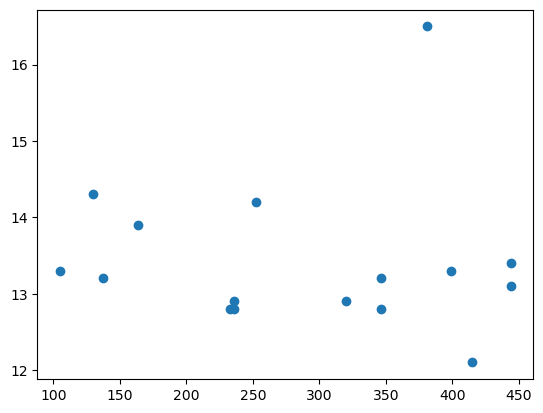

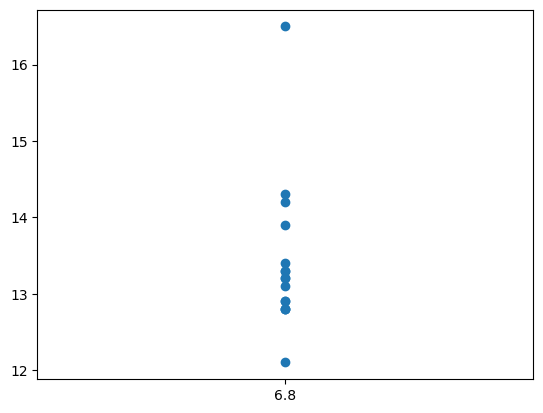

In [161]:
plt.scatter(hypdist_list, trans_time_list)
plt.show()

plt.scatter(mags_list, trans_time_list)
plt.show()

In [93]:
summary = az.summary(mcmc)

In [94]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m1,1.608,0.390,1.130,2.124,0.274,0.231,2.0,11.0,2.84
m2,0.013,0.003,0.011,0.019,0.002,0.001,3.0,21.0,2.24
xinter,11.131,0.335,10.699,11.574,0.235,0.198,2.0,10.0,2.69
sigma,0.106,0.037,0.067,0.177,0.024,0.020,2.0,13.0,2.32


In [77]:
summary['mean']

m1         0.302
m2         0.039
xinter    12.971
sigma      0.163
Name: mean, dtype: float64

In [82]:
m1 = summary['mean'].iloc[0]
m2 = summary['mean'].iloc[1]
xinter = summary['mean'].iloc[2]
sigma = summary['mean'].iloc[3]

In [85]:
print(sigma)

0.163


In [87]:
# Done, now is post-processing to get the data out of the sampler

summary = az.summary(mcmc)

# Unwrap coeficients
m1 = summary['mean'].iloc[0]
m2 = summary['mean'].iloc[1]
xinter = summary['mean'].iloc[2]
sigma = summary['mean'].iloc[3]
b1 = y0 - m1*x0
b2 = m1*xinter + b1 - m2*xinter

In [88]:
# Make plot to check stuff
xpredicted = np.arange(xobserved.min(), xobserved.max()+0.1, 0.1)
ypredicted = np.ones(len(xpredicted))
ypredicted = m1*xpredicted + b1
i = np.where(xpredicted > xinter)[0]
ypredicted[i] = m2*xpredicted[i] + b2

In [90]:
posterior = az.extract(mcmc)

In [95]:
posterior

<xarray.Dataset> Size: 224kB
Dimensions:  (sample: 4000)
Coordinates:
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
Data variables:
    m1       (sample) float64 32kB 0.2794 0.2794 0.2794 ... 0.3114 0.3114 0.3114
    m2       (sample) float64 32kB 0.0466 0.0466 0.0466 ... 0.04077 0.04077
    xinter   (sample) float64 32kB 12.98 12.98 12.99 12.99 ... 12.95 12.94 12.94
    sigma    (sample) float64 32kB 0.1522 0.1522 0.1522 ... 0.1575 0.1575 0.1575
Attributes:
    created_at:                 2024-03-05T10:45:23.481163
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.4
    sampling_time:              8.208245038986206
    tuning_steps:               1000

In [99]:
len(posterior.m1.values)

4000